In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

path = str(Path(Path('thermo.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from tools.cbook import pickle2Obj

import pickle

_nthreads = 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
#--------------------------------------------------------------------------------------------
def plot_profile(profile, var, zhgts, ax, color, mlabel, step=None, percentile=None, linewidth=2.0, linestyle='solid'):

    label = "%s NOBJ:  %d" % (mlabel, profile[var].shape[1])

    p = profile[var]
        
    if step != None:
        t0 = profile['tindex'][step[0]]
        t1 = profile['tindex'][step[1]]
        p = p[:,t0:t1]
    
    if percentile != None:
        psort = np.sort(p)
        idx   = np.int(percentile * psort.shape[0])
        if idx > 0 and idx < psort.shape[0]:
            p = psort[:,idx:]
        else:
            p = np.zeros_like(psort)
            
    label = "%s NOBJ:  %d" % (mlabel, p.shape[1])       
            
    ax.plot(p.mean(axis=1), zhgts, color=color, linewidth=linewidth, label=label, linestyle=linestyle)

#--------------------------------------------------------------------------------------------
# define plotting sub

def plot_wprofile_driver(models, variable = 'w', step = [1,16], plabel = "", percentile=None):

    titles = ["0-6 Hour Updraft Profiles", "2-4 Hour Updraft Profiles", "4-6 Hour Updraft Profiles"]

    xvert  = [6.0, 8.0, 12.5]
    if percentile == None:
        xlim   = [10.0, 8.0, 8.0]
    else:
         xlim   = [15.0, 10.0, 10.0]

    zhgts = 250. + 250.*np.arange(100)
    
    allcape = ( "C2000", "C3500")
    allshear = ("06", "18")
        
    for cape in allcape:
        
        fig, ax = plt.subplots(1,len(allcape), constrained_layout=True,figsize=(7*len(allcape),10))

        for n, shear in enumerate(allshear):
                       
            label = "%s_%s" % (cape, shear)

            for key in models:

                mdata = models[key][label]
                
                if key == 'solo':
                    plot_profile(mdata, variable, zhgts, ax[n], 'r', "FV3-NOR3", step=step, linewidth=2.0, percentile=percentile)
                
                if key == 'solo2':
                    plot_profile(mdata, variable, zhgts, ax[n], 'g', "FV3-NOR2", step=step, linewidth=1.0, linestyle='-', percentile=percentile)
                    
                if key == 'solo1':
                    plot_profile(mdata, variable, zhgts, ax[n], 'g', "FV3-NOR1", step=step, linewidth=1.0, linestyle='--', percentile=percentile)

                if key == 'cm1':
                    plot_profile(mdata, variable, zhgts, ax[n], 'b', "CM1", step=step, linewidth=2.0, percentile=percentile)

                if key == 'wrf':
                    plot_profile(mdata, variable, zhgts, ax[n], 'k', "WRF", step=step, linewidth=2.0, percentile=percentile)

            if percentile == None:
                ax[n].set_title("%s SHEAR: %s (m/s)" % (titles[0],shear), fontsize=14)
            else:
                ax[n].set_title("(%d percentile) %s SHEAR: %s (m/s)" % (np.int(percentile*100), titles[0],shear), fontsize=14)
                
            ax[n].axhline(y=6000., color='k', linestyle='-')
            ax[n].axhline(y=8000., color='k', linestyle='-')
            ax[n].axhline(y=10000., color='k', linestyle='-')
            ax[n].axvline(x=0.0, color='k', linestyle='--')
            ax[n].axvline(x=xvert[0], color='k', linestyle='--')
            ax[n].legend(fontsize=14, loc='upper right')
            ax[n].set_xlim(-2.0,xlim[0])
            ax[n].set_xlabel("%s" % variable, fontsize=18)
            ax[n].set_ylabel("Height(m)", fontsize=18)
            ax[n].set_ylim(0.0,25000.)

            plt.suptitle("%s  CAPE = %s" % (plabel, cape[1:]), fontsize=24)
            if percentile == None:
                plt.savefig("WProfiles_%s_Experiment_%s.png" % (plabel,label))
            else:
                plt.savefig("WProfiles_%d percentile_%s_Experiment_%s.png" % (np.int(percentile*100), plabel,label))
            
        plt.show()

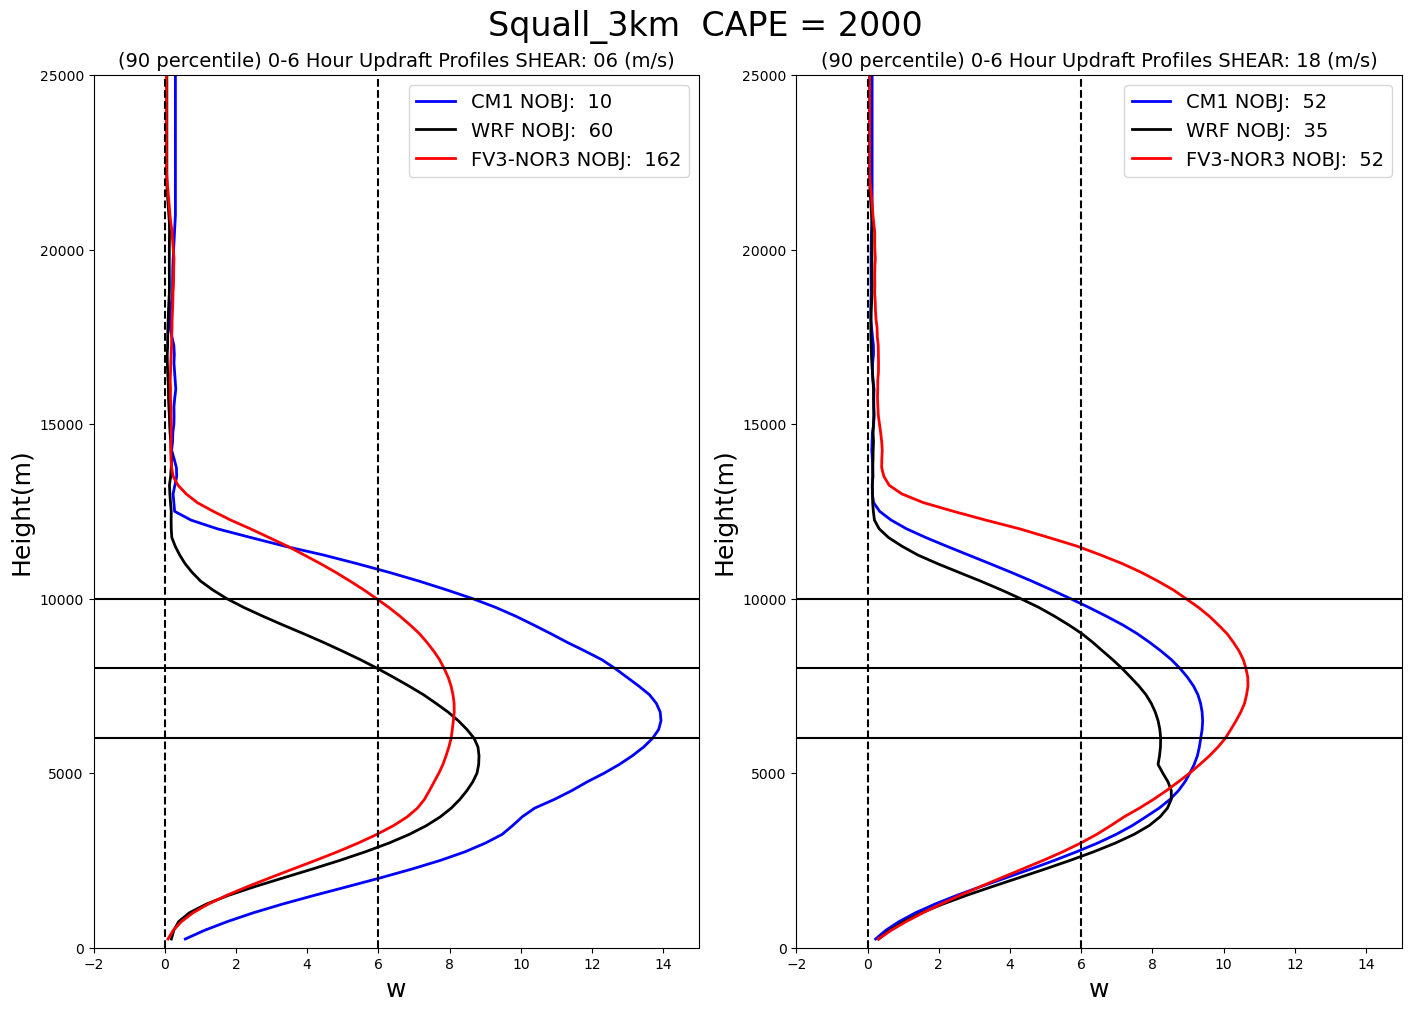

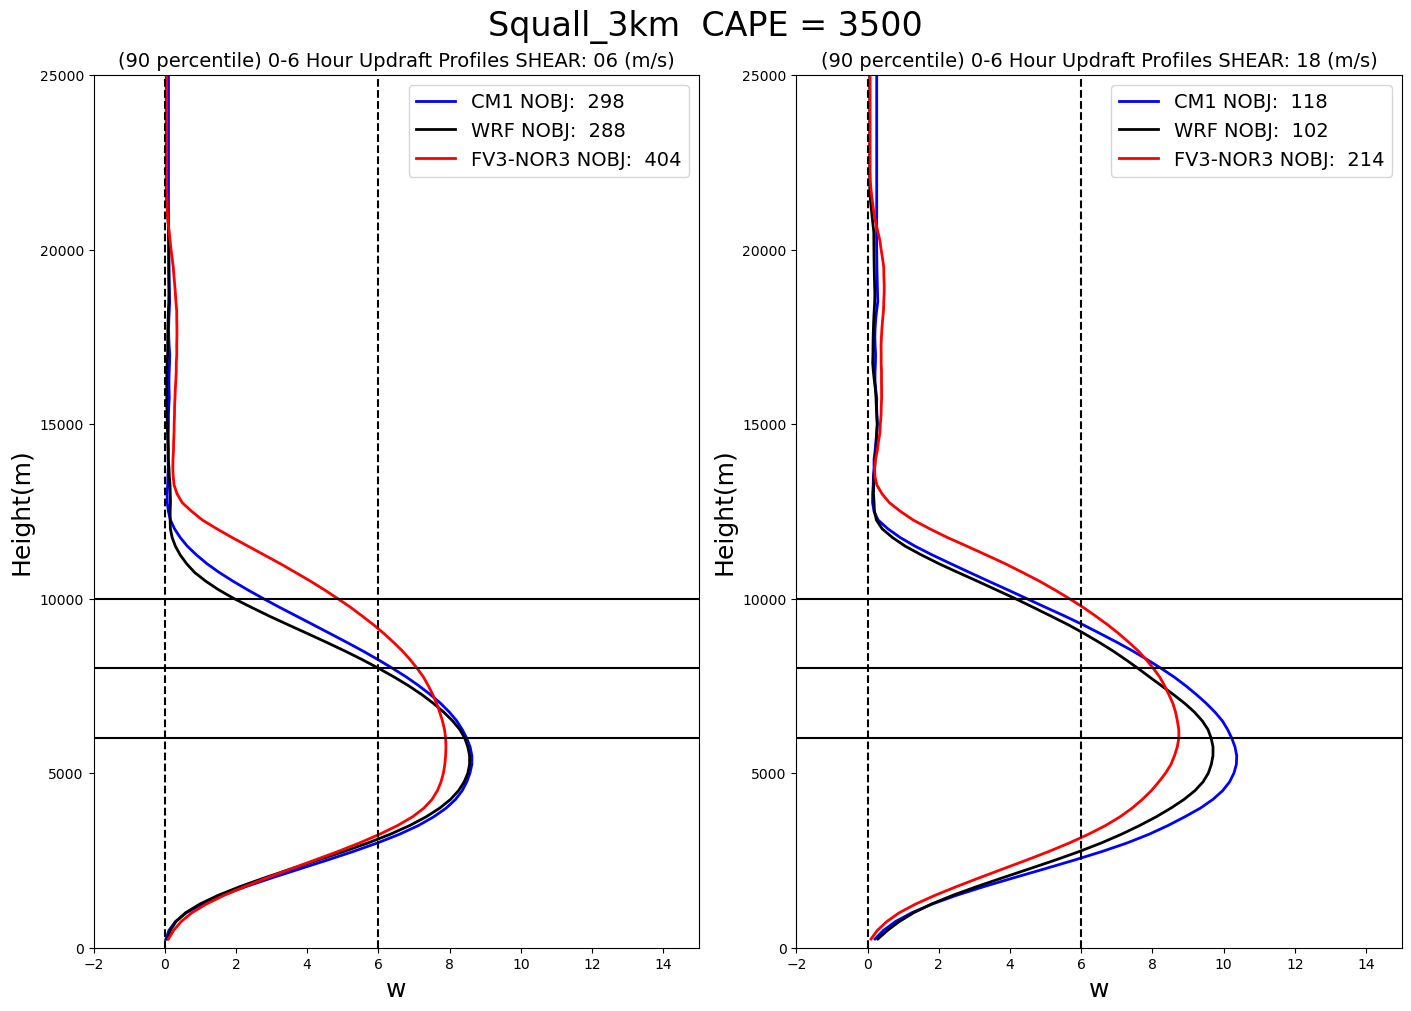

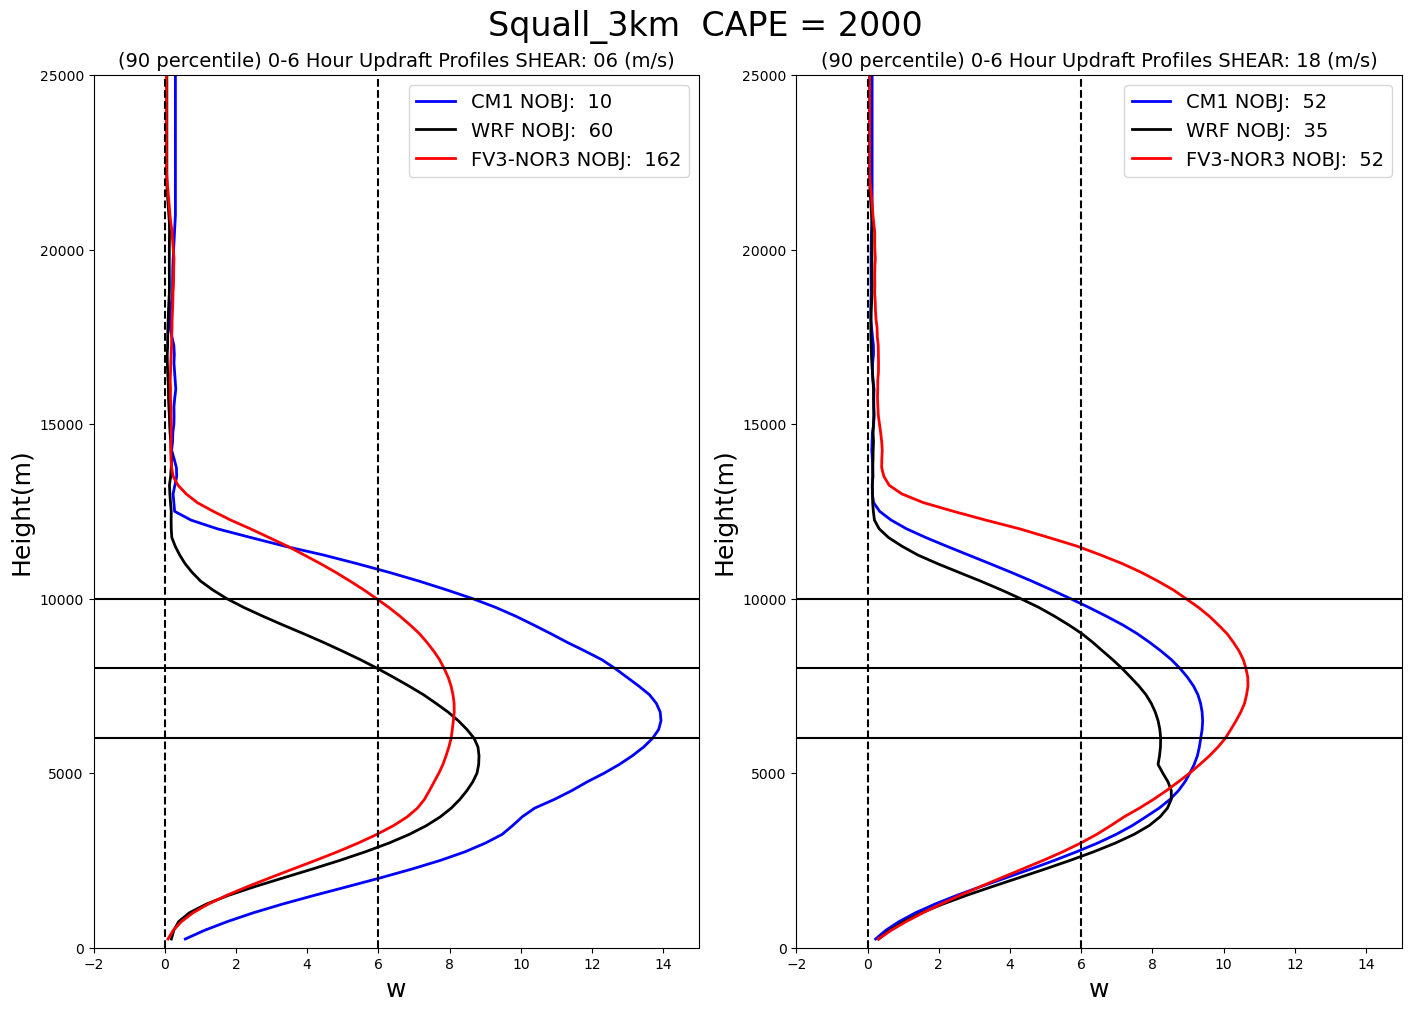

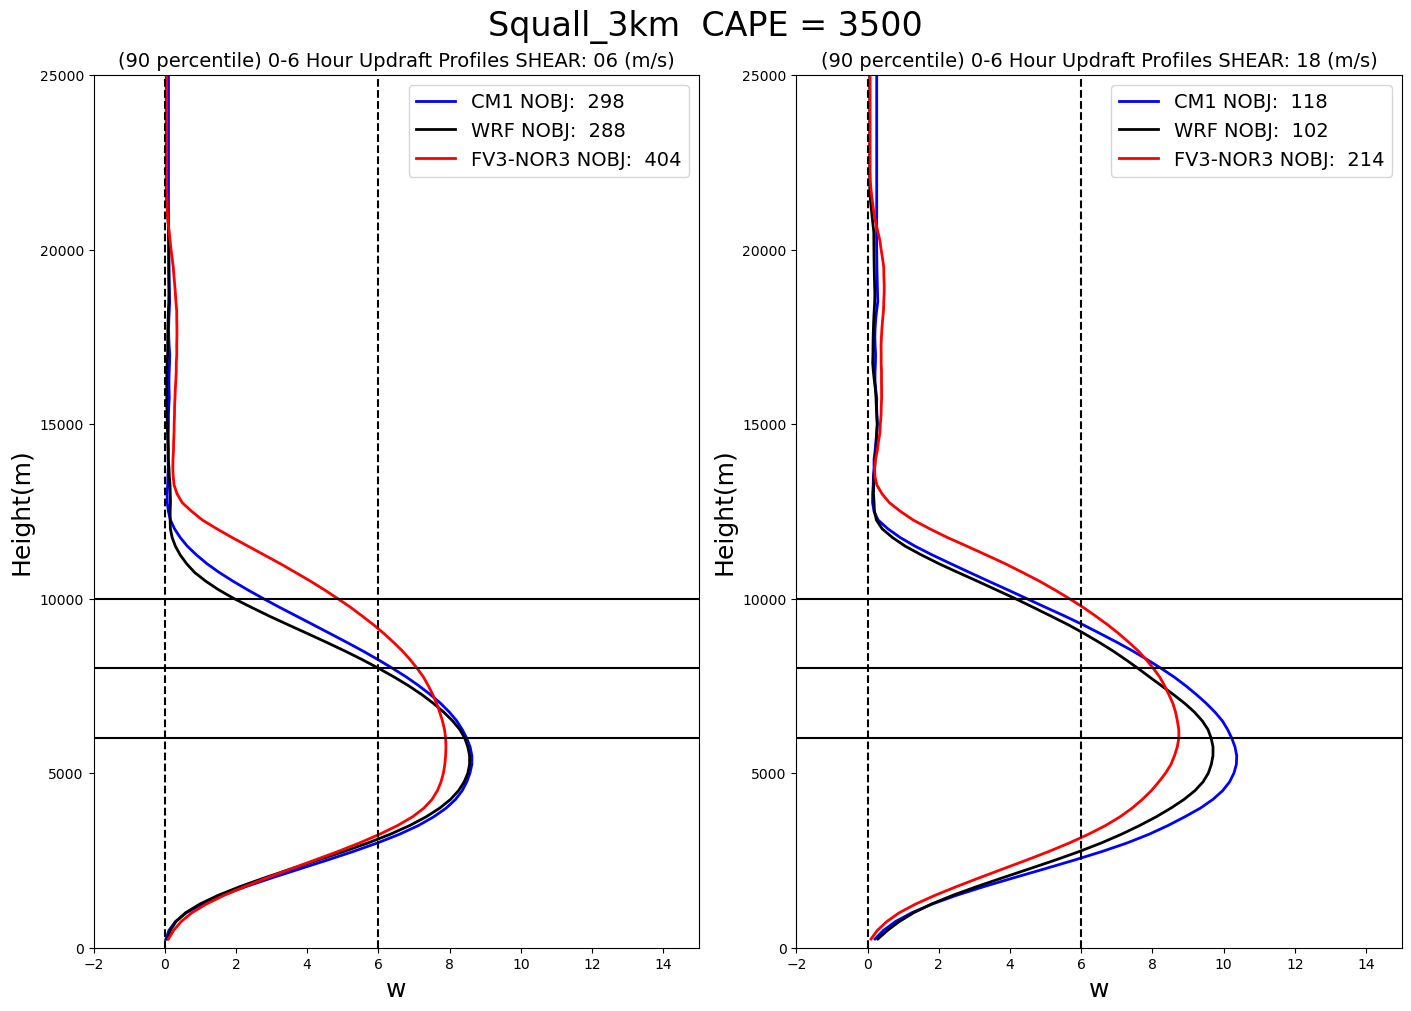

In [54]:
# Just read stuff back in...

models = { 'cm1': pickle2Obj('profiles/cm1_squall_3km_27Apr.pkl',retObj=False),
           'wrf': pickle2Obj('profiles/wrf_squall_3km_27Apr.pkl', retObj=False),
           'solo': pickle2Obj('profiles/solo_squall_3km_27Apr.pkl',retObj=False),
           # 'solo2': pickle2Obj('profiles/solo_squall_3km_nord2_35dbz_profiles.pkl',retObj=False),
           # 'solo1': pickle2Obj('profiles/solo_squall_3km_nord1_35dbz_profiles.pkl',retObj=False) 
         }

plot_wprofile_driver(models, plabel = 'Squall_3km', percentile=0.9)

models = { 'cm1': pickle2Obj('profiles/cm1_squall_1km_27Apr.pkl',retObj=False),
           'wrf': pickle2Obj('profiles/wrf_squall_1km_27Apr.pkl', retObj=False),
           'solo': pickle2Obj('profiles/solo_squall_1km_27Apr.pkl',retObj=False)
         }

models = { 'cm1': pickle2Obj('profiles/cm1_squall_3km_35dbz_profiles.pkl',retObj=False),
           'wrf': pickle2Obj('profiles/wrf_squall_3km_35dbz_profiles.pkl', retObj=False),
           'solo': pickle2Obj('profiles/solo_squall_3km_35dbz_profiles.pkl',retObj=False),
           # 'solo2': pickle2Obj('profiles/solo_squall_3km_nord2_35dbz_profiles.pkl',retObj=False),
           # 'solo1': pickle2Obj('profiles/solo_squall_3km_nord1_35dbz_profiles.pkl',retObj=False) 
         }

plot_wprofile_driver(models, plabel = 'Squall_3km', percentile=0.9)



In [56]:
#----------------------------------------------------
def plot_sizes_driver(models, plabel=""):
    
    titles = ["0-6 Hour Updraft Sizes", "0-2 Hour Updraft Sizes", "2-4 Hour Updraft Sizes"]

    allcape = ("C2000", "C3500")
    allshear = ("06", "18")
    
    step = [[0,-1], [0,8],[8,16]]

    for cape in allcape:

        for shear in allshear:   # create dictionary names
            
            label = "%s_%s" % (cape, shear)
            
            fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))
            
            for key in models:
                
                mdata = models[key]

                for n, s in enumerate(step):

                    t0 = mdata[label]['tindex'][s[0]]
                    t1 = mdata[label]['tindex'][s[1]]
                    ss = np.sort(mdata[label]['size'][t0:t1])

                    zhgt = np.arange(len(ss))/float(len(ss))

                    if key == 'solo':
                        ax[n].plot(ss, zhgt, color='r', label='FV3-NOR3', linewidth=2.0)
                        
                    if key == 'solo2':
                        ax[n].plot(ss, zhgt, color='g', label='FV3-NOR2', linewidth=2.0, linestyle='--')
                
                    if key == 'solo1':
                        ax[n].plot(ss, zhgt, color='g', label='FV3-NOR1', linewidth=2.0, linestyle='-')
                        
                    if key == 'cm1':
                        ax[n].plot(ss, zhgt, color='b', label='CM1', linewidth=2.0)
                    
                    if key == 'wrf':
                        ax[n].plot(ss, zhgt, color='k', label='WRF', linewidth=2.0)

                    ax[n].set_title("%s - (Updraft Size in Pixels)" % (titles[n]), fontsize=14)
                    ax[n].axhline(y=0.5, color='k', linestyle='--')
                    ax[n].axhline(y=0.9,  color='k', linestyle='--')

                    ax[n].set_ylim(0.0,1.1)
                    ax[n].set_xlim(0,50)
                    ax[n].legend(fontsize=14, loc='lower right')
            
            plt.suptitle("%s %s" % (plabel, label), fontsize=18)

            

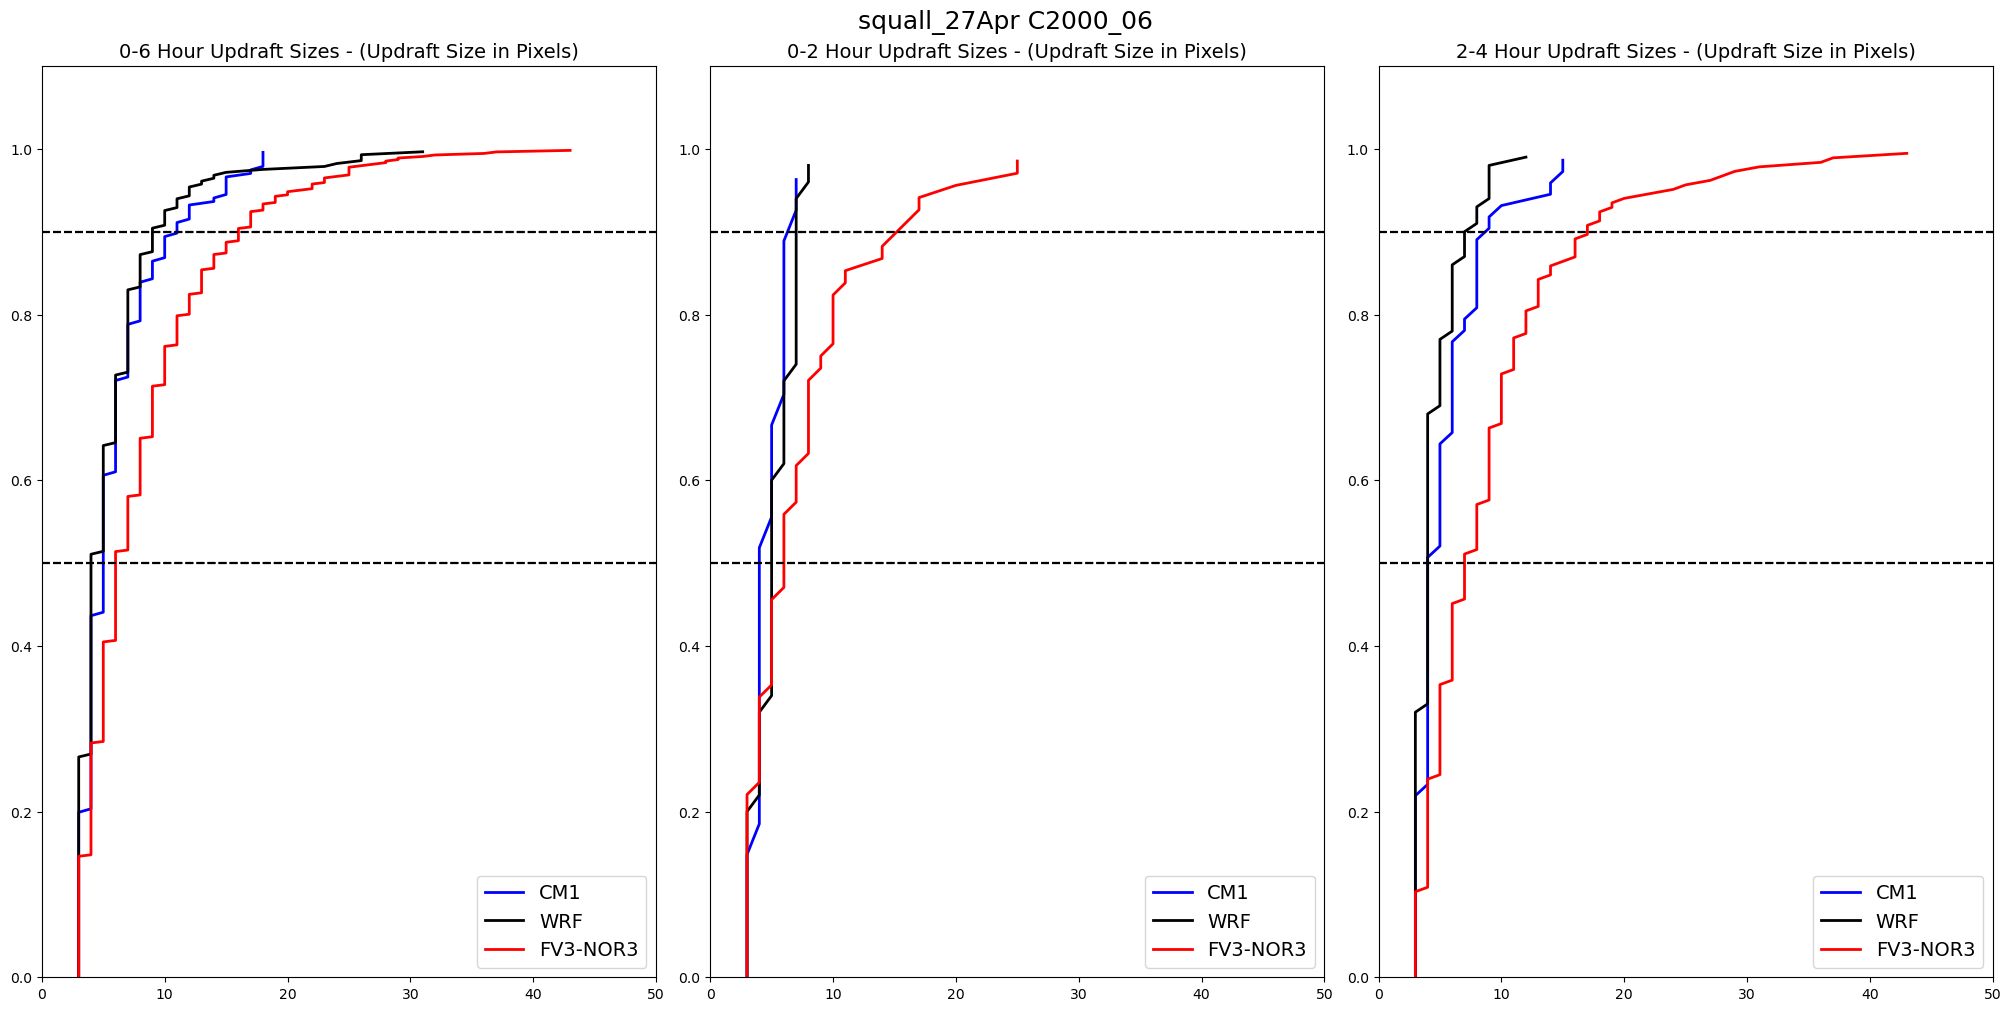

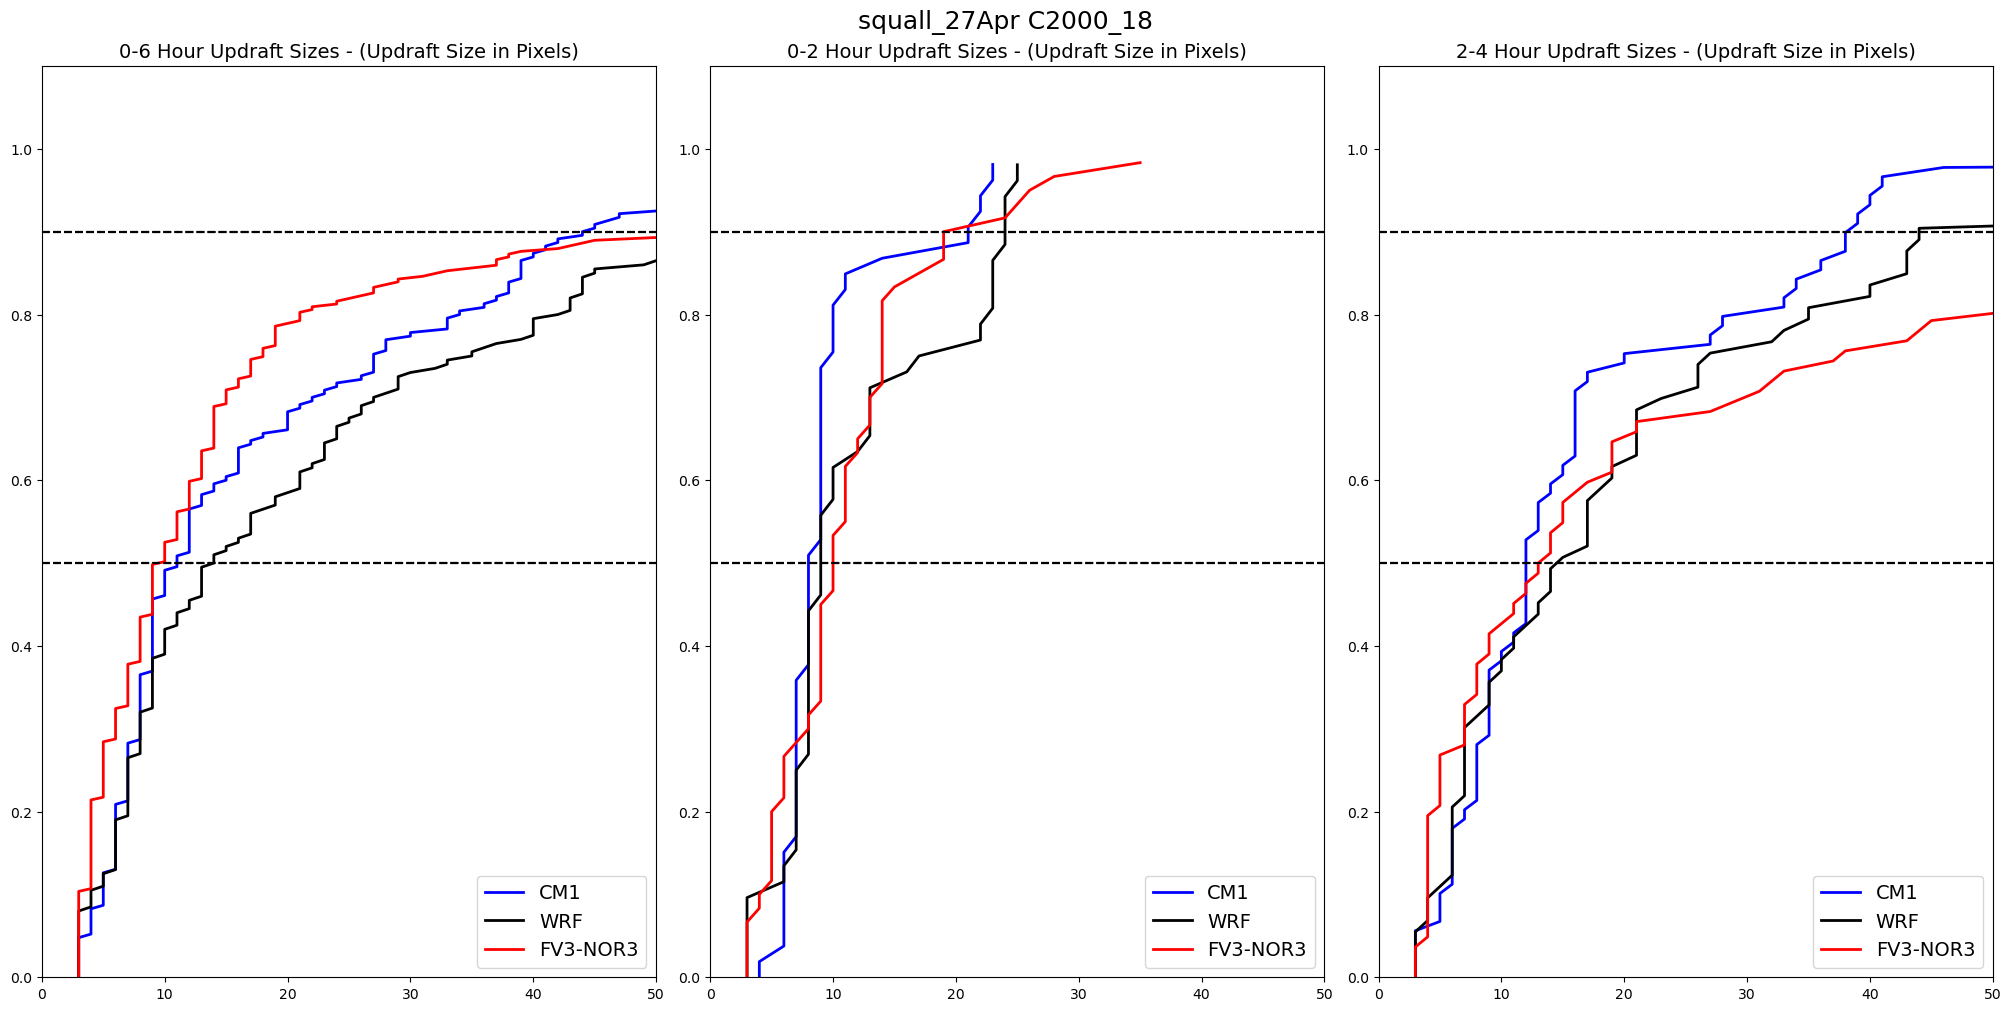

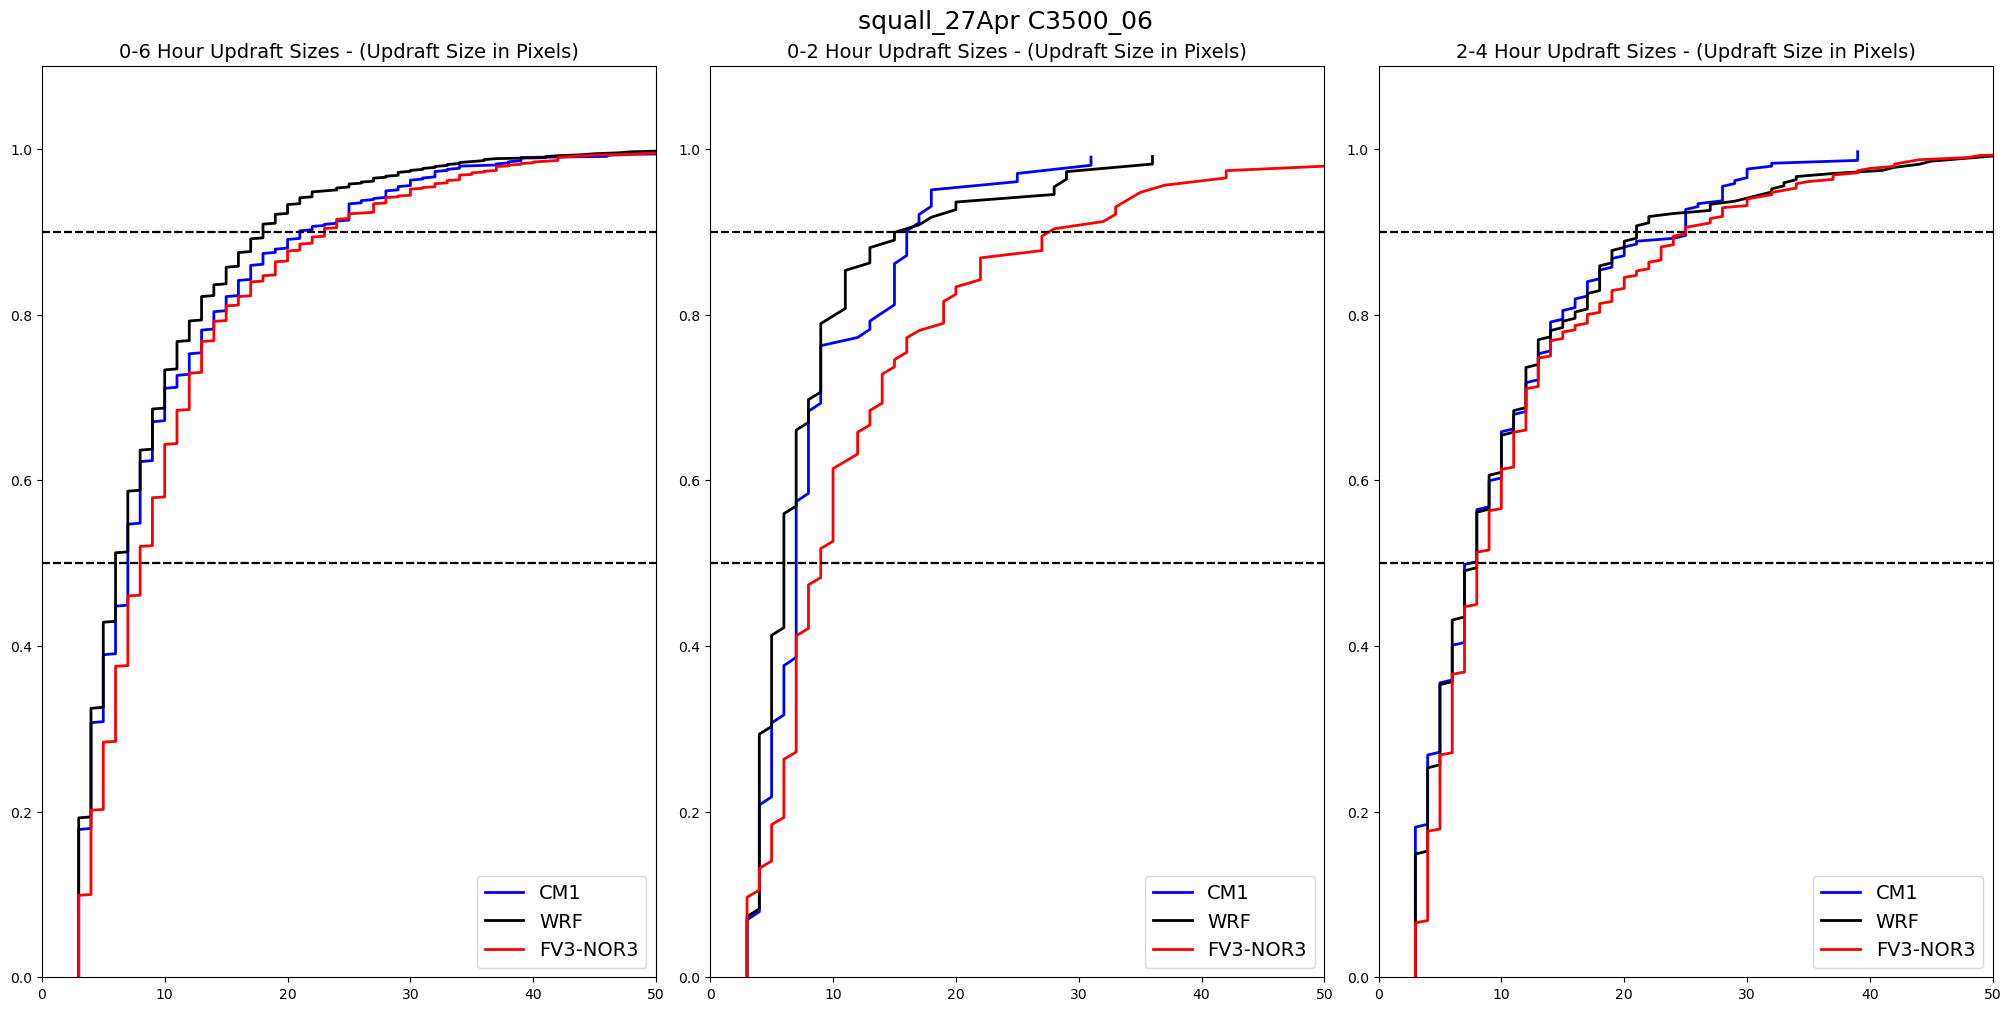

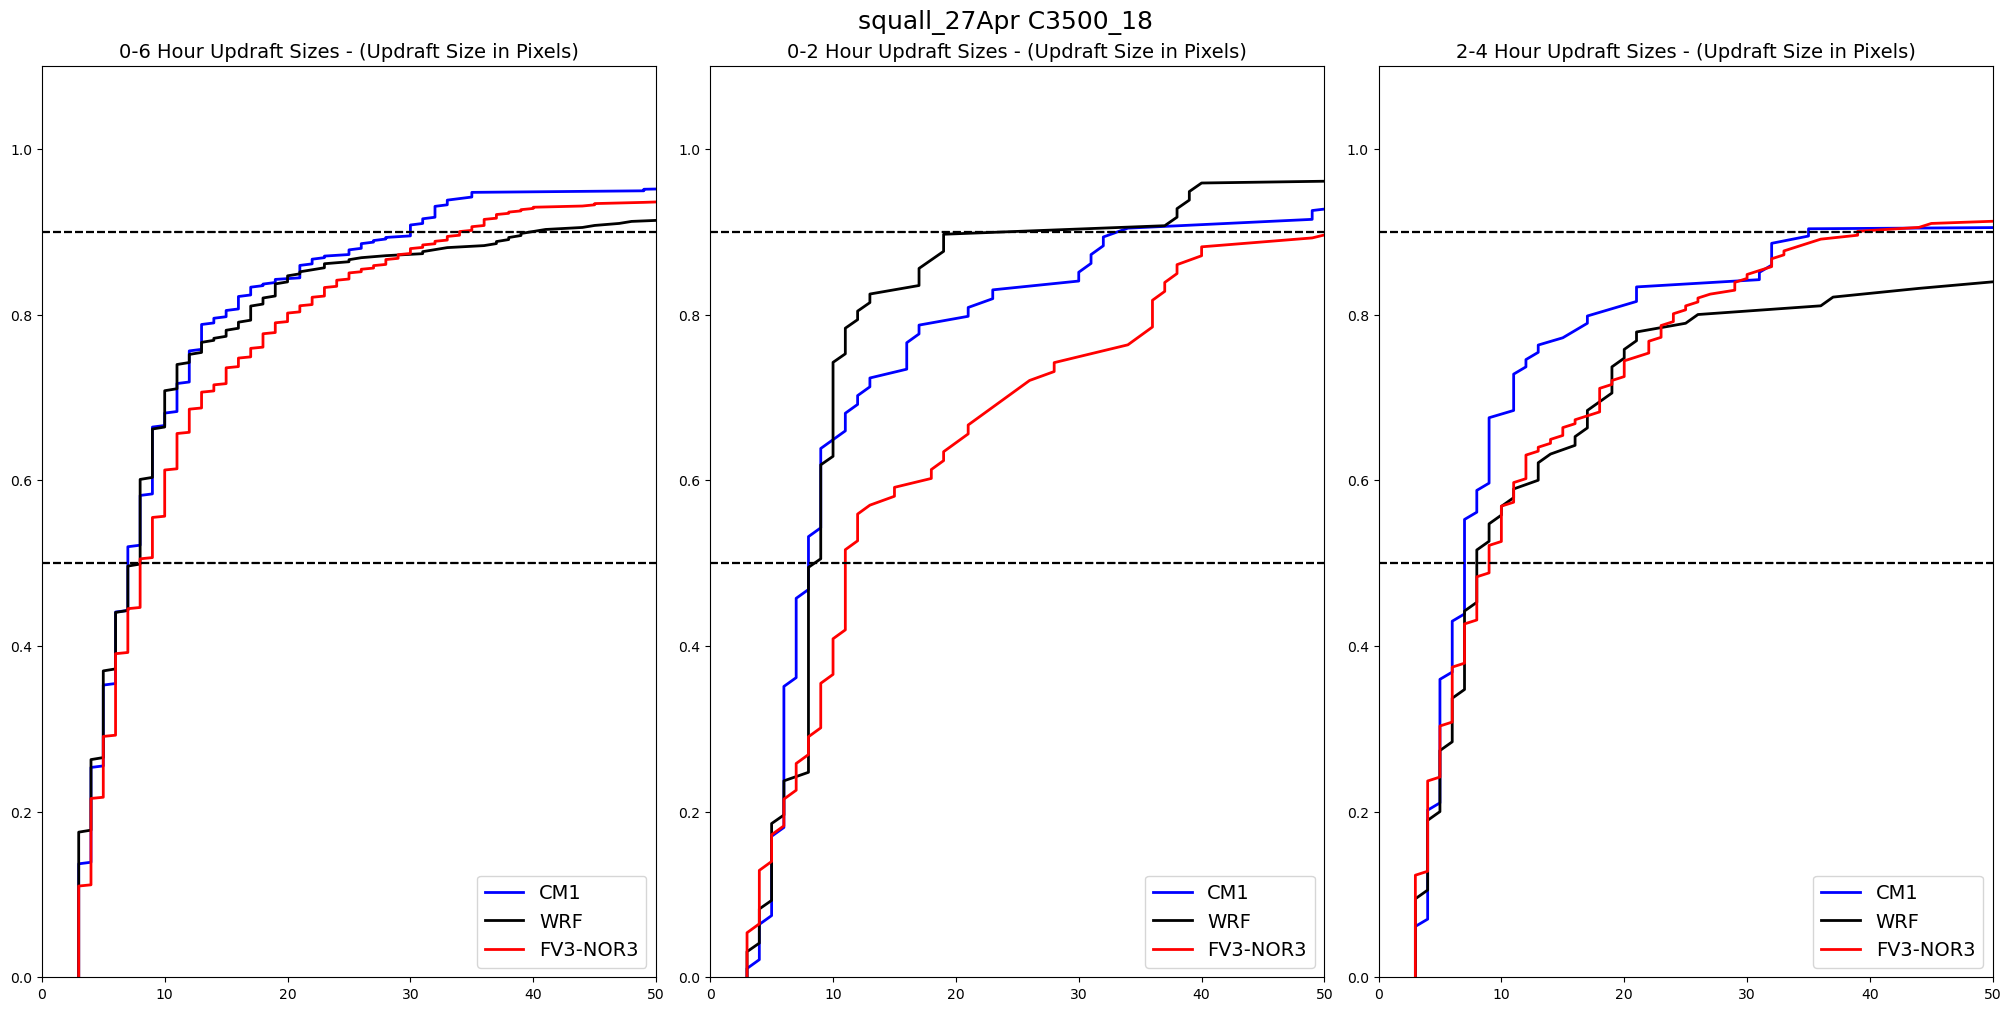

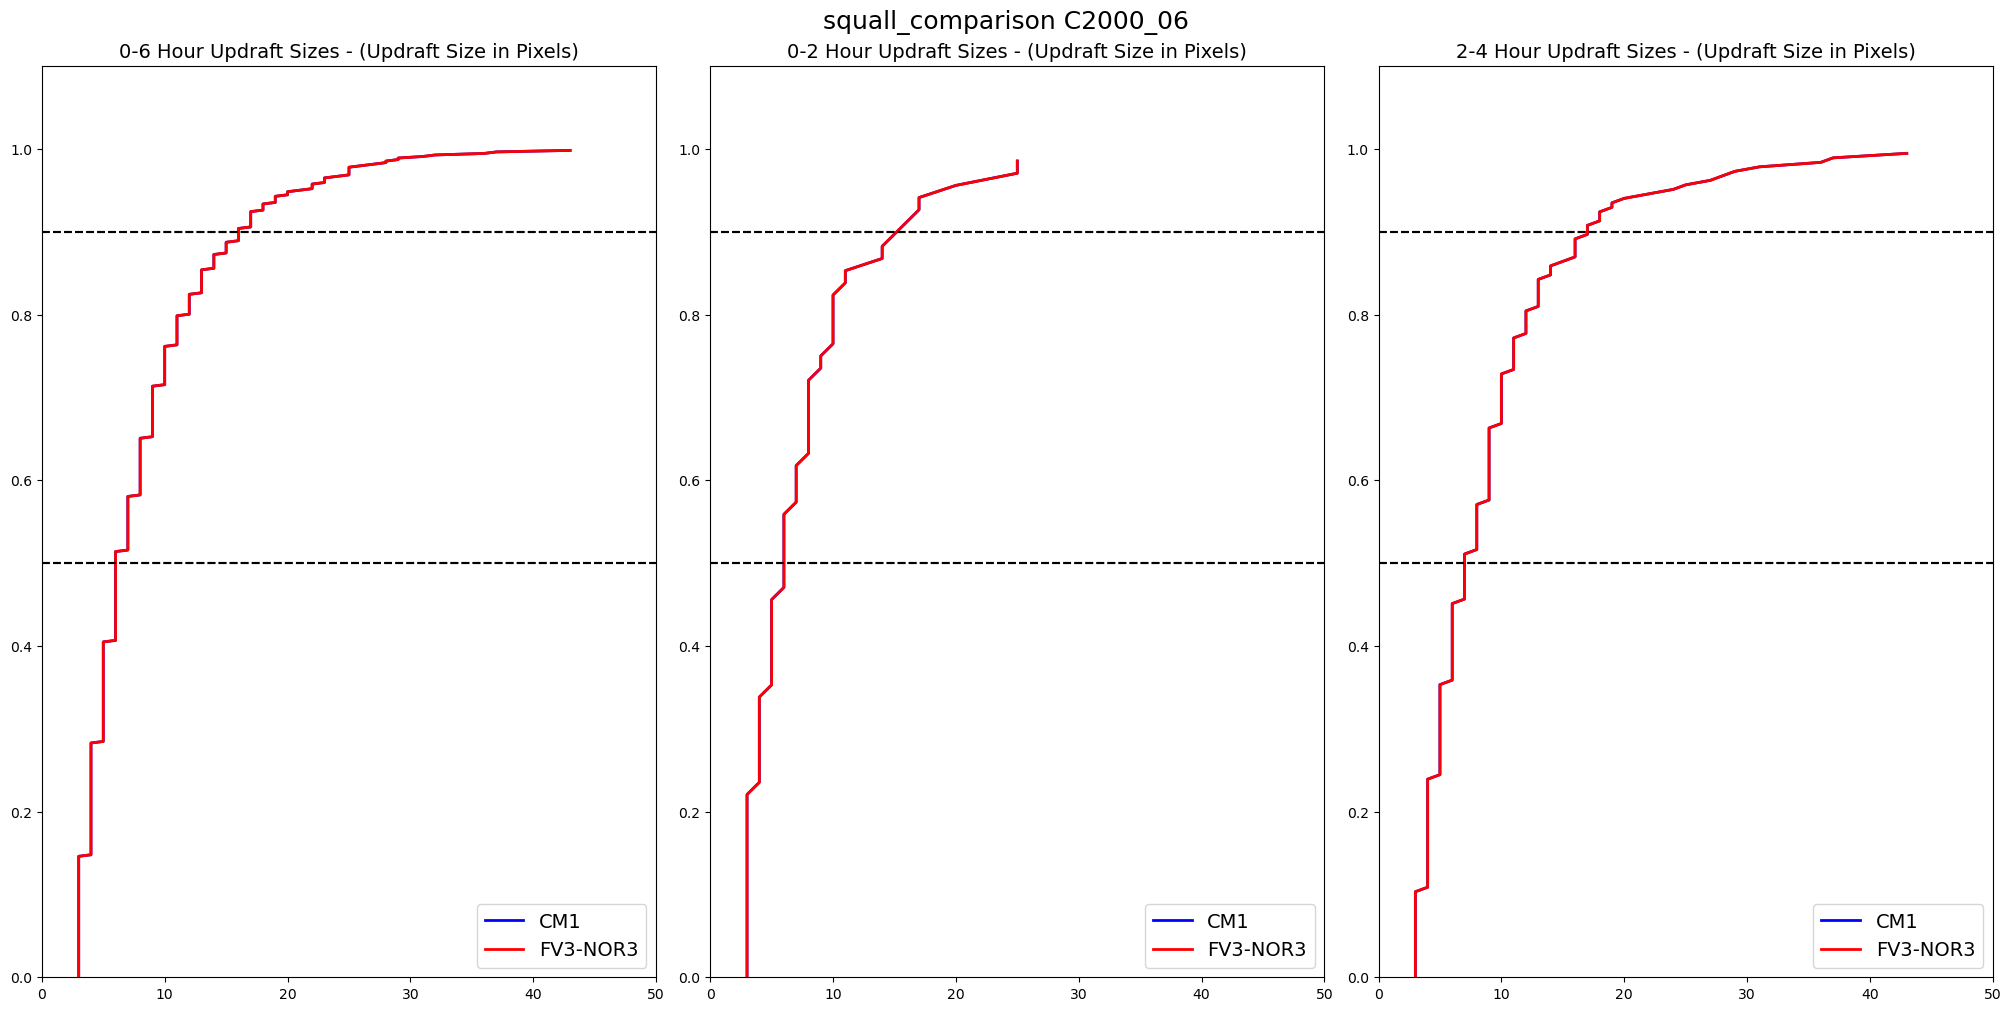

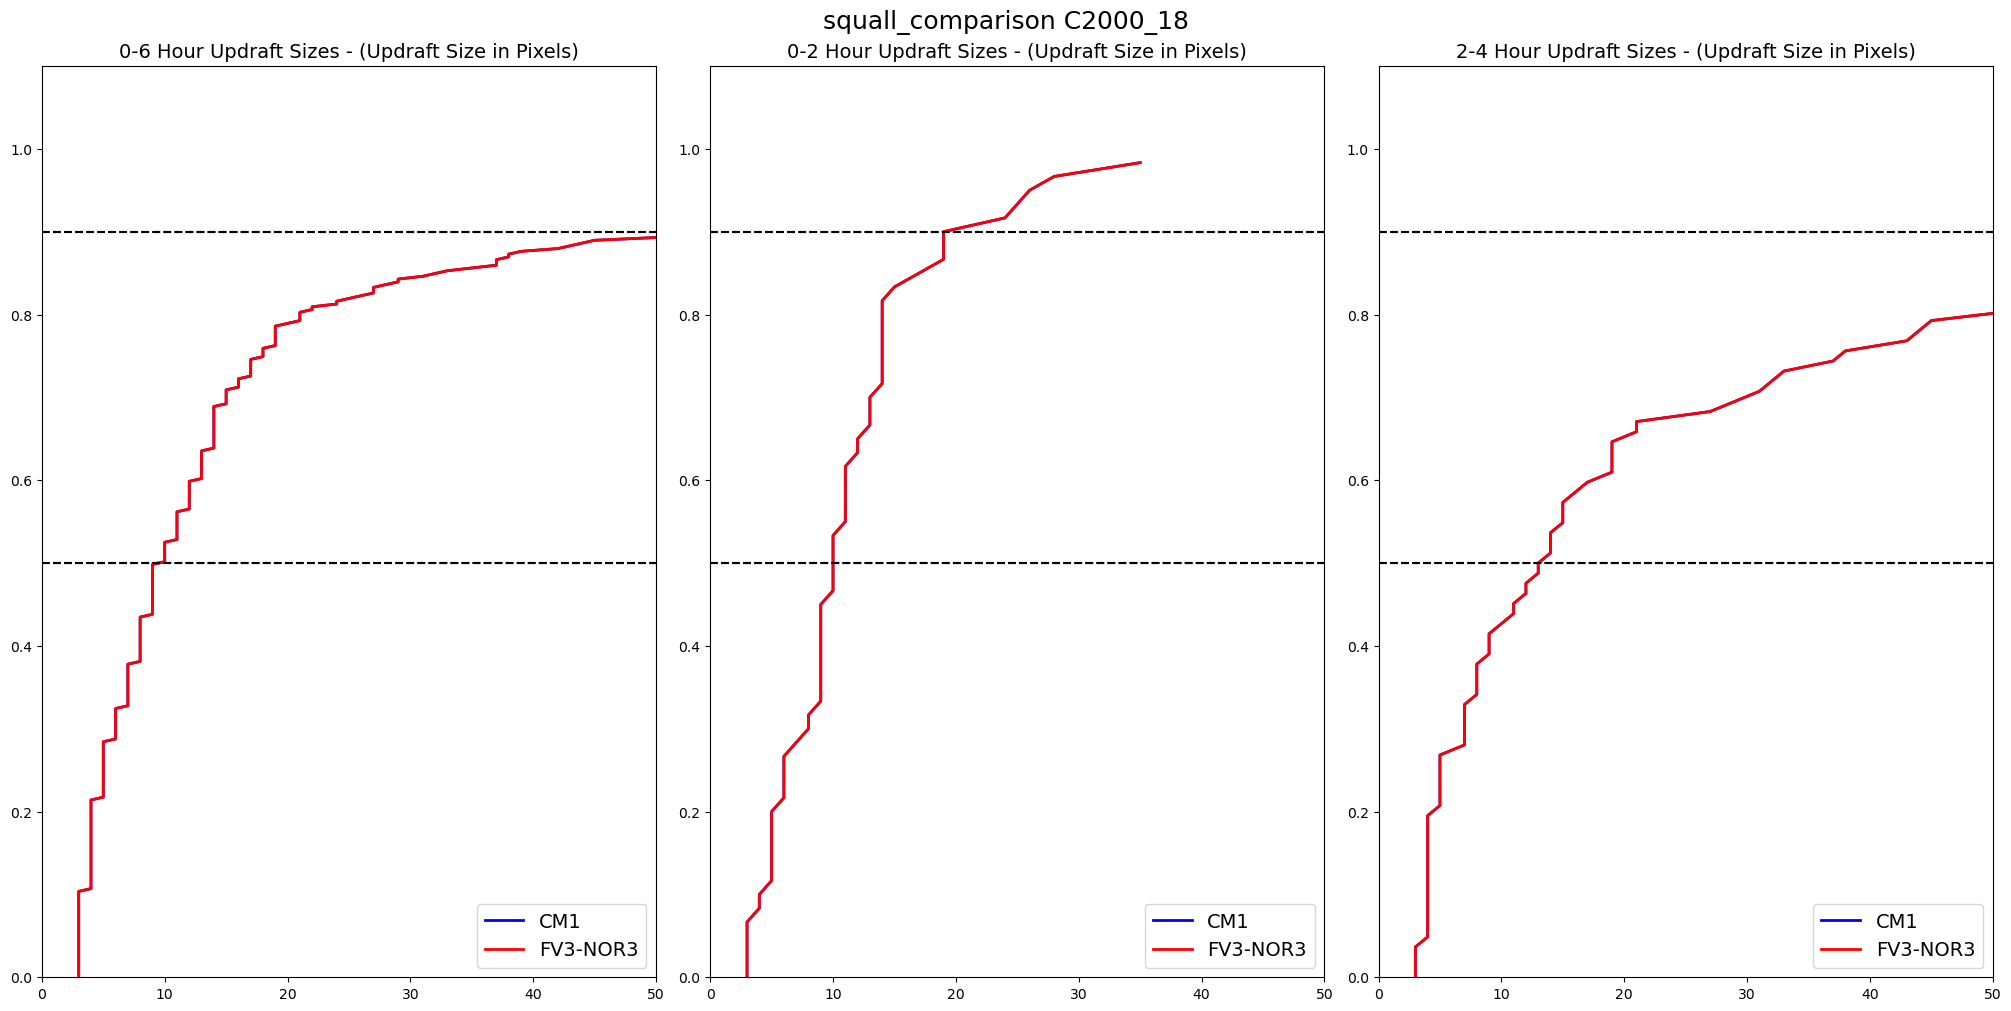

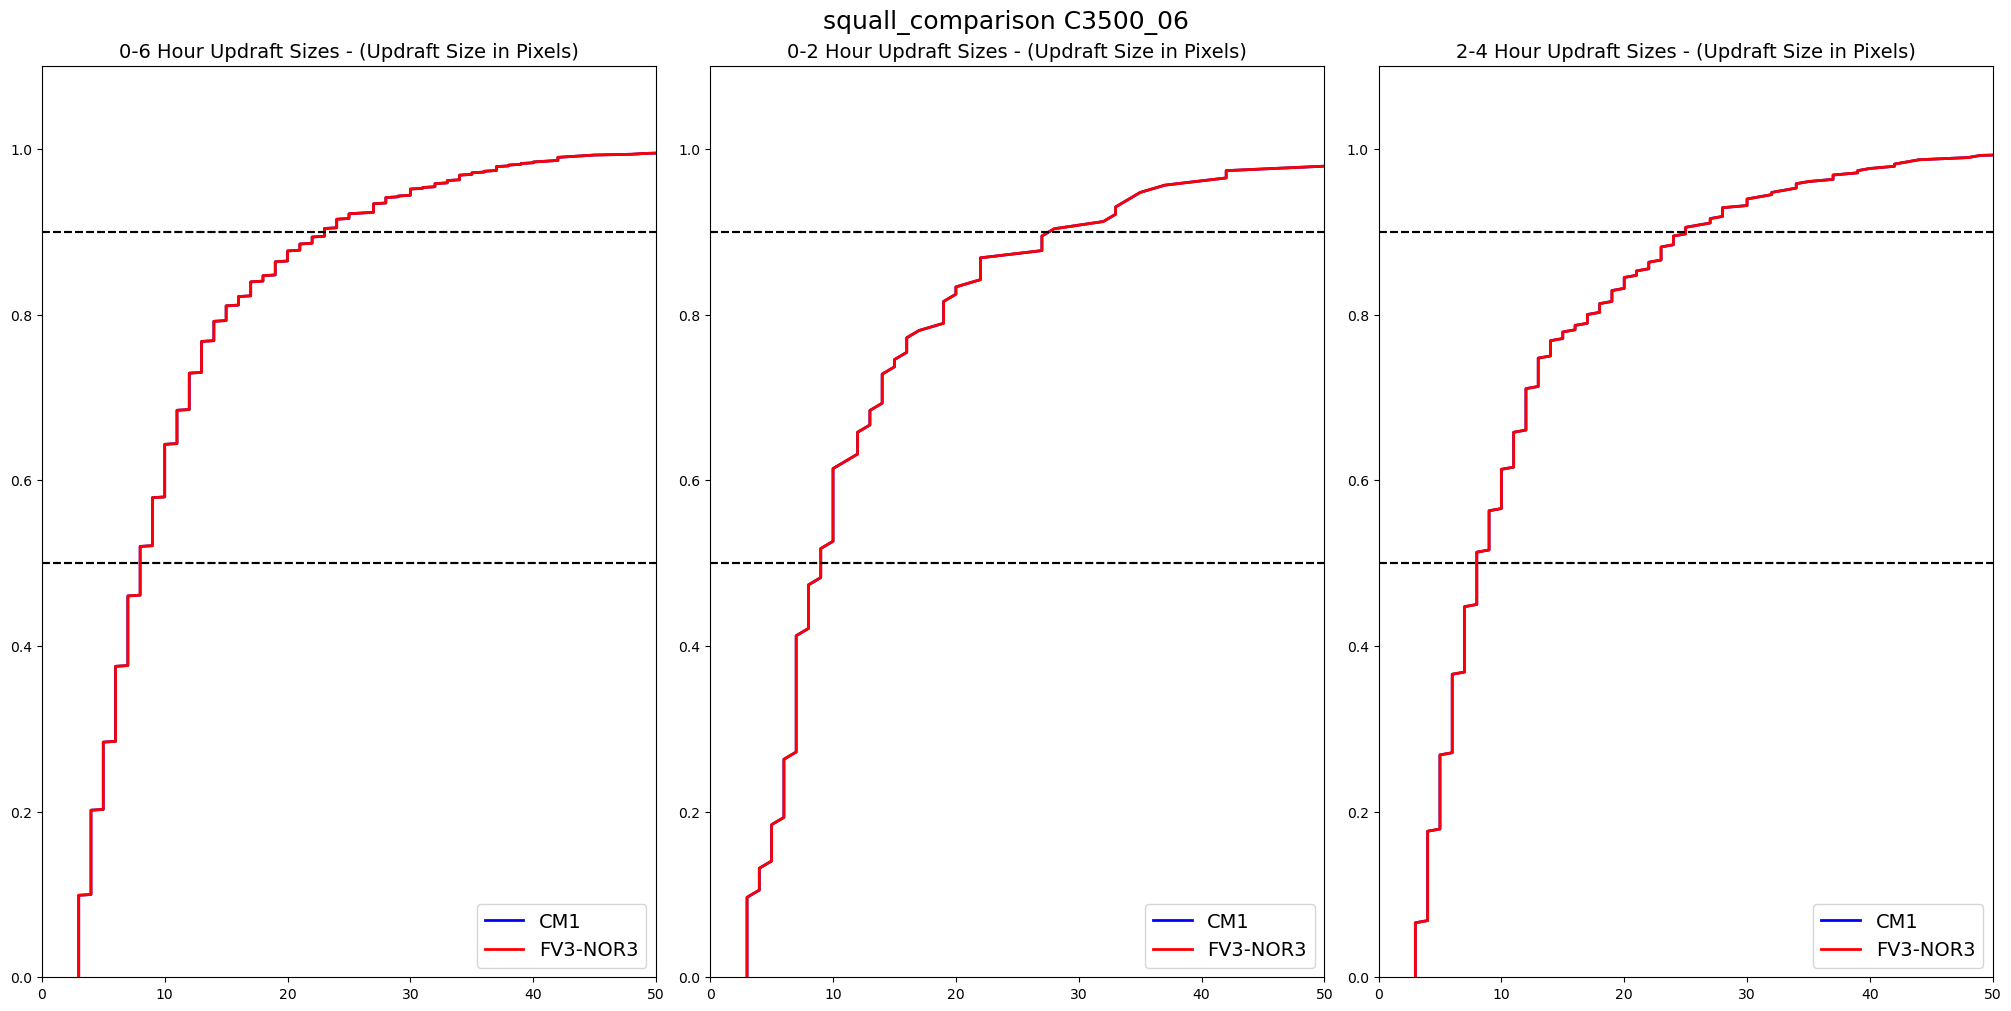

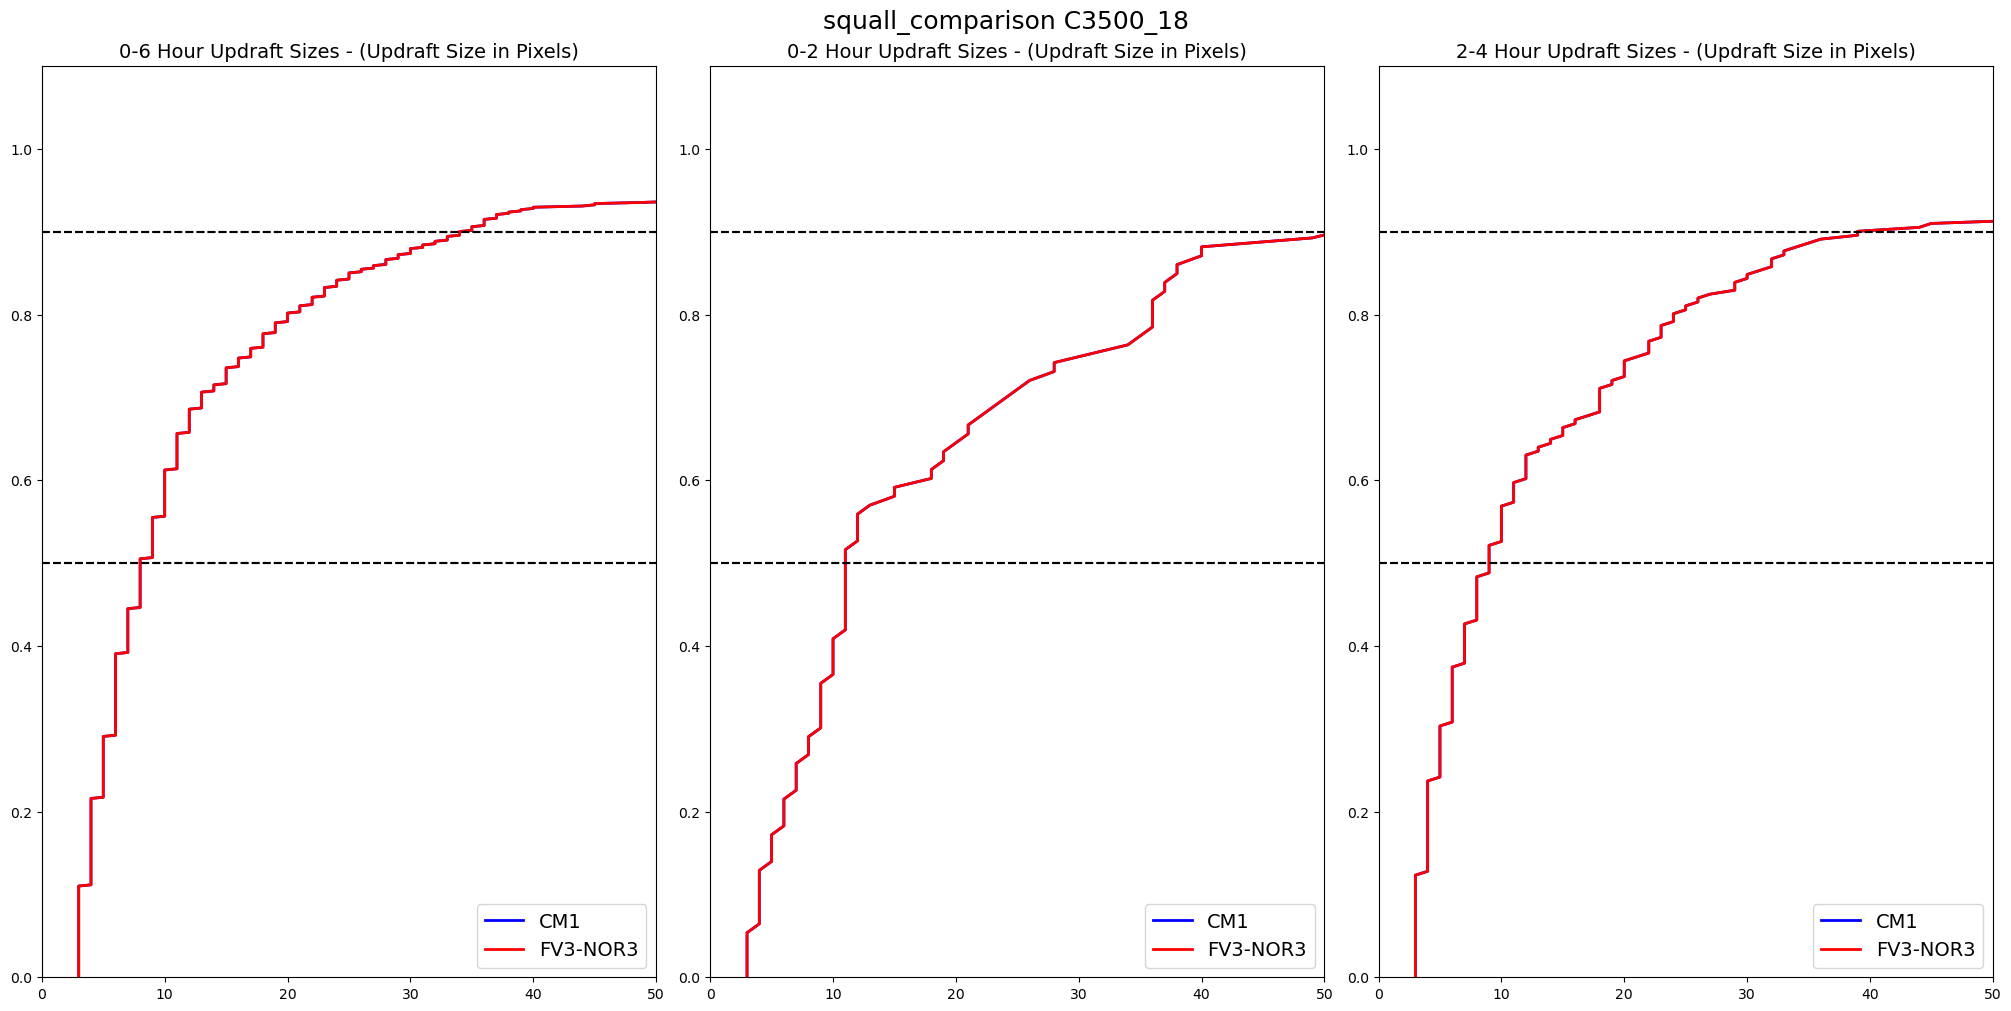

In [61]:

models = { 'cm1': pickle2Obj('profiles/cm1_squall_3km_27Apr.pkl',retObj=False),
           'wrf': pickle2Obj('profiles/wrf_squall_3km_27Apr.pkl', retObj=False),
           'solo': pickle2Obj('profiles/solo_squall_3km_27Apr.pkl',retObj=False),
           # 'solo2': pickle2Obj('profiles/solo_squall_3km_nord2_35dbz_profiles.pkl',retObj=False),
           # 'solo1': pickle2Obj('profiles/solo_squall_3km_nord1_35dbz_profiles.pkl',retObj=False) 
         }

plot_sizes_driver( models, plabel = 'squall_27Apr' )

models = { 'cm1': pickle2Obj('profiles/cm1_squall_3km_35dbz_profiles.pkl',retObj=False),
           'wrf': pickle2Obj('profiles/wrf_squall_3km_35dbz_profiles.pkl', retObj=False),
           'solo': pickle2Obj('profiles/solo_squall_3km_35dbz_profiles.pkl',retObj=False),
           # 'solo2': pickle2Obj('profiles/solo_squall_3km_nord2_35dbz_profiles.pkl',retObj=False),
           # 'solo1': pickle2Obj('profiles/solo_squall_3km_nord1_35dbz_profiles.pkl',retObj=False) 
         }

models = { 'cm1': pickle2Obj('profiles/solo_squall_3km_27Apr.pkl',retObj=False),
           'solo': pickle2Obj('profiles/solo_squall_3km_35dbz_profiles.pkl',retObj=False),
           # 'solo2': pickle2Obj('profiles/solo_squall_3km_nord2_35dbz_profiles.pkl',retObj=False),
           # 'solo1': pickle2Obj('profiles/solo_squall_3km_nord1_35dbz_profiles.pkl',retObj=False) 
         }
            
plot_sizes_driver( models, plabel = 'squall_comparison' )


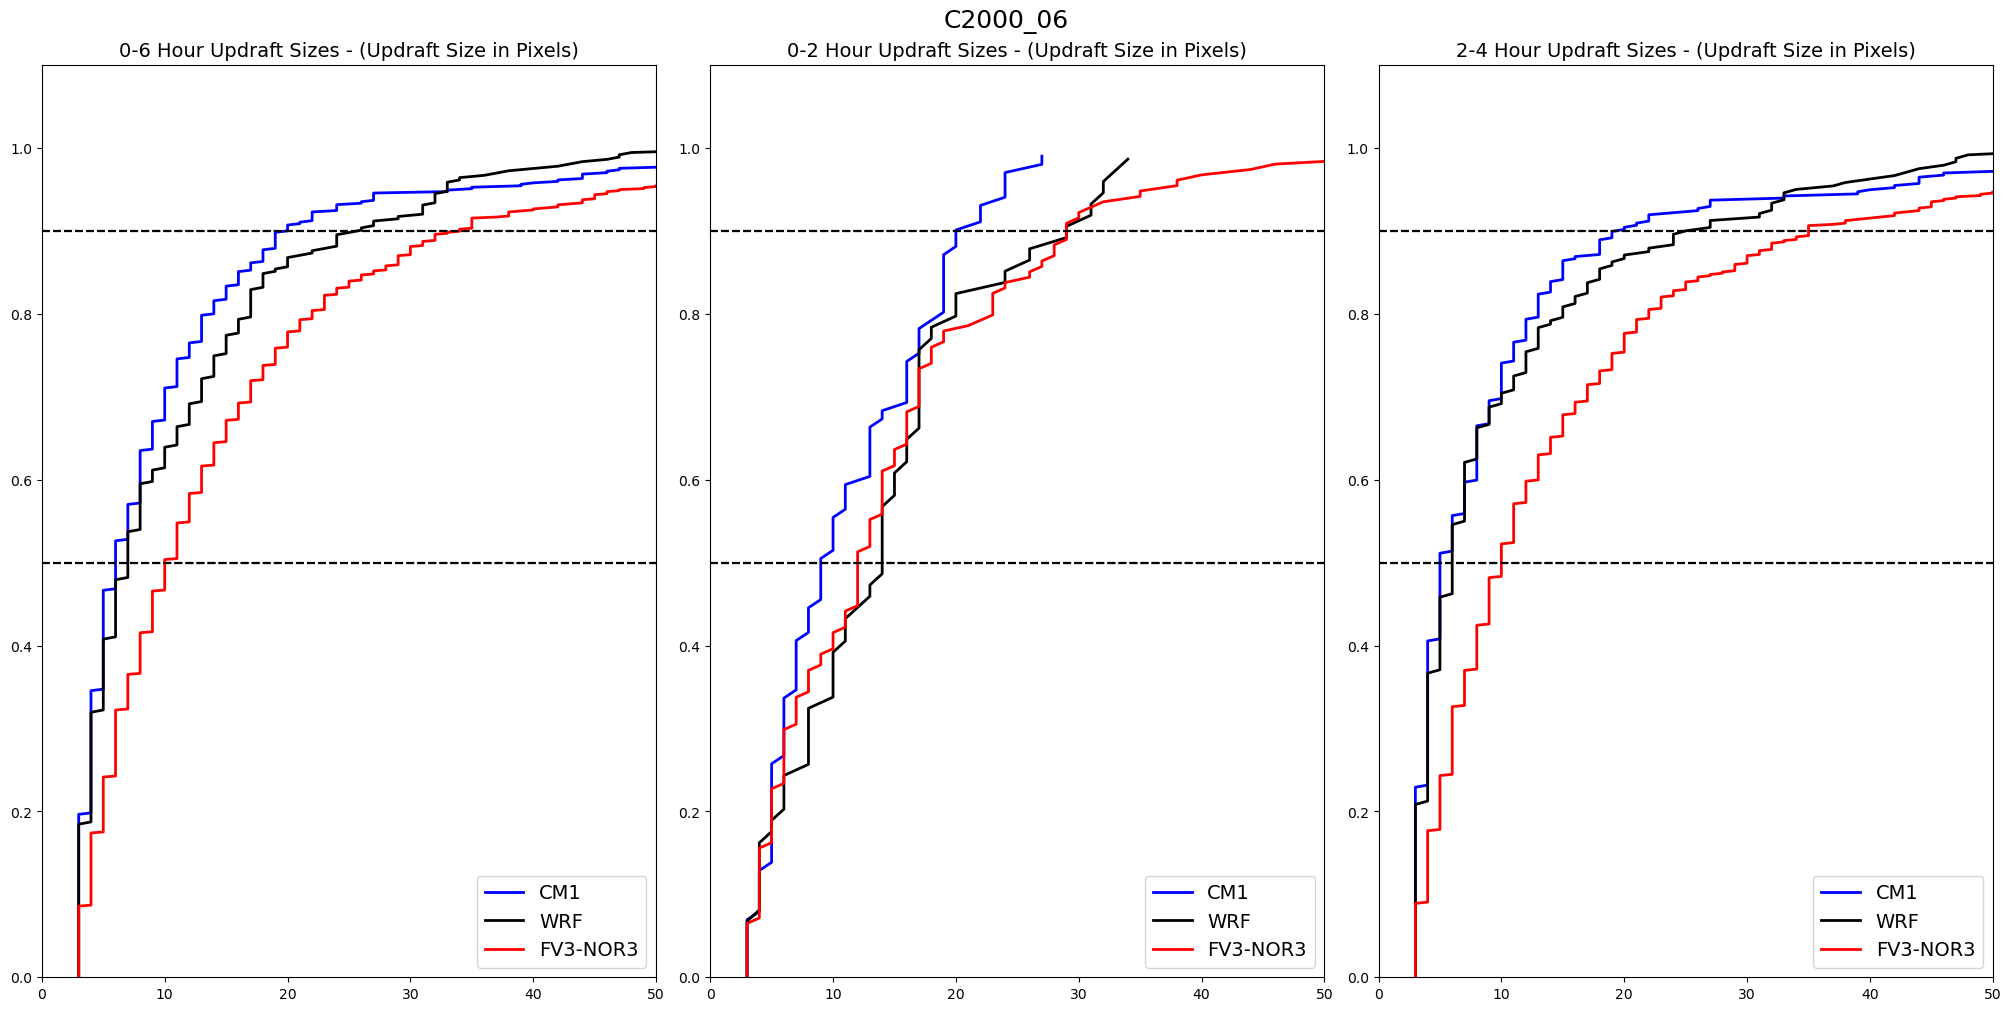

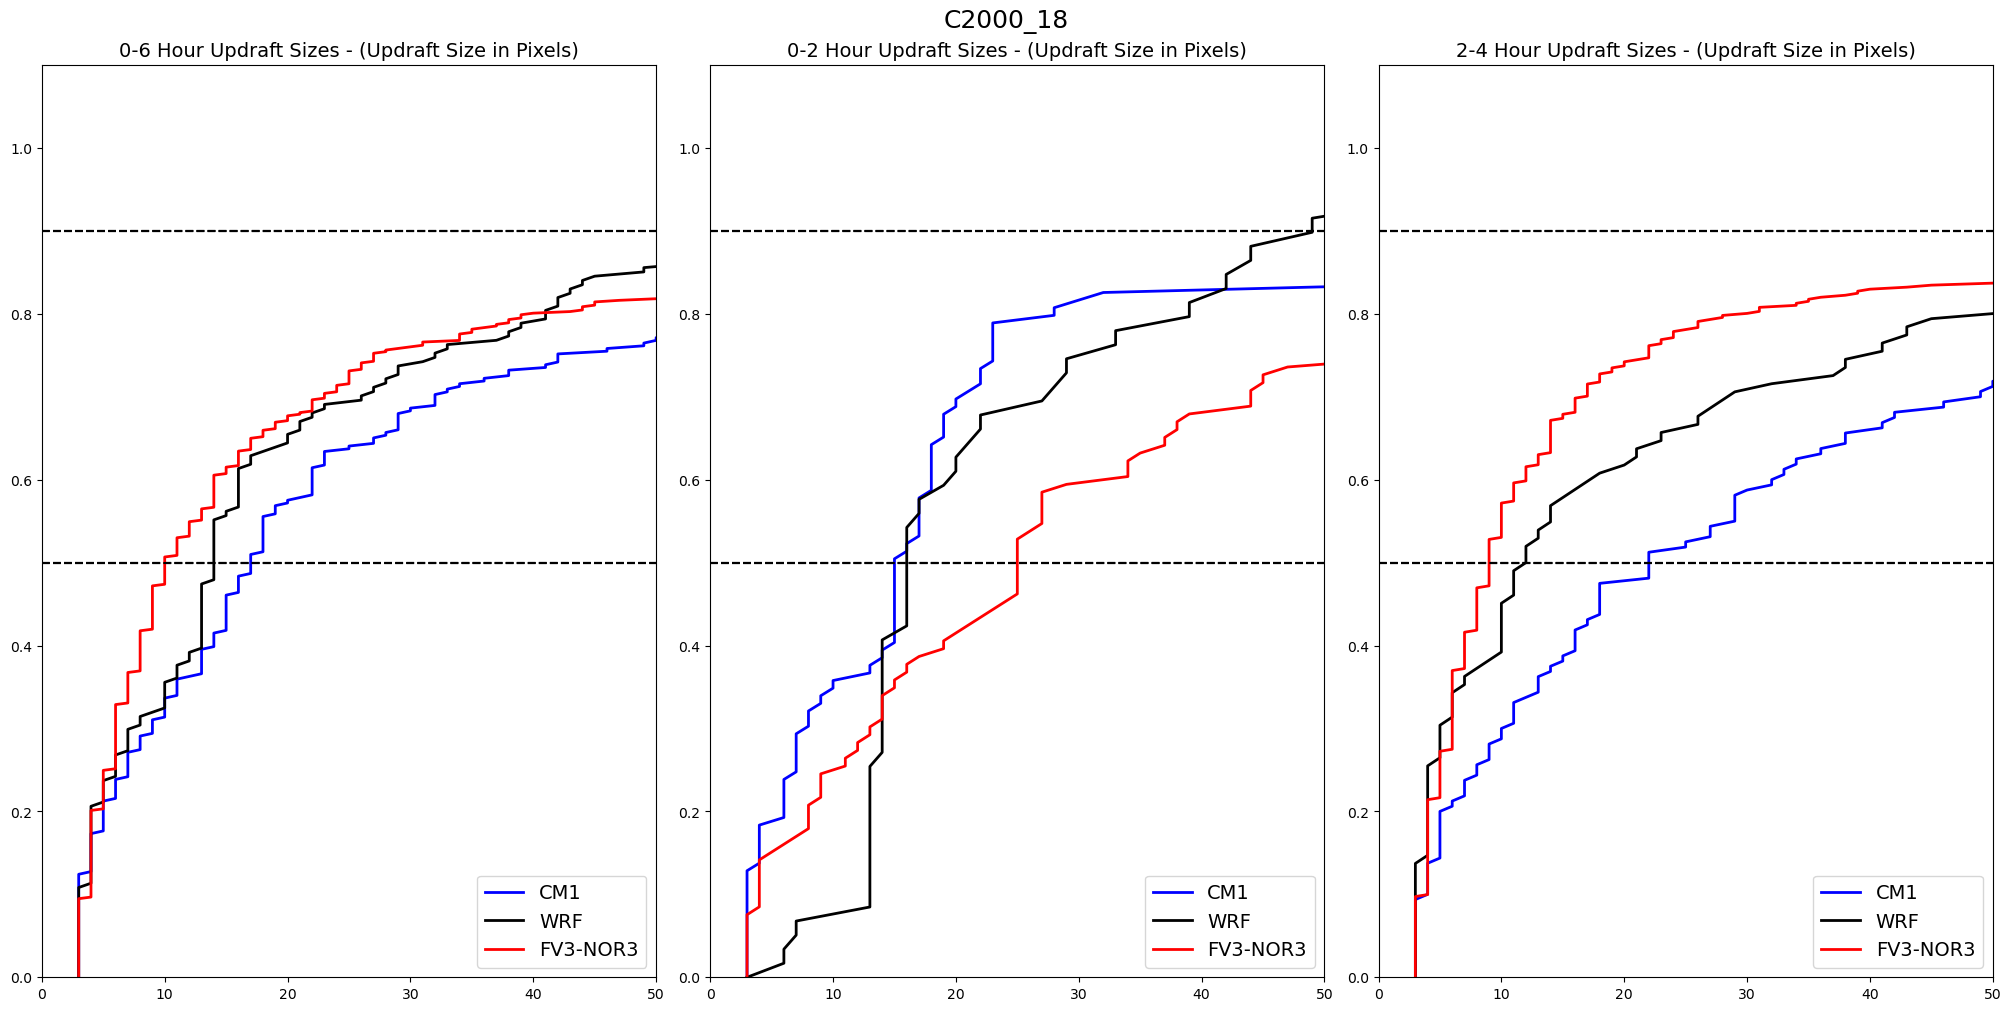

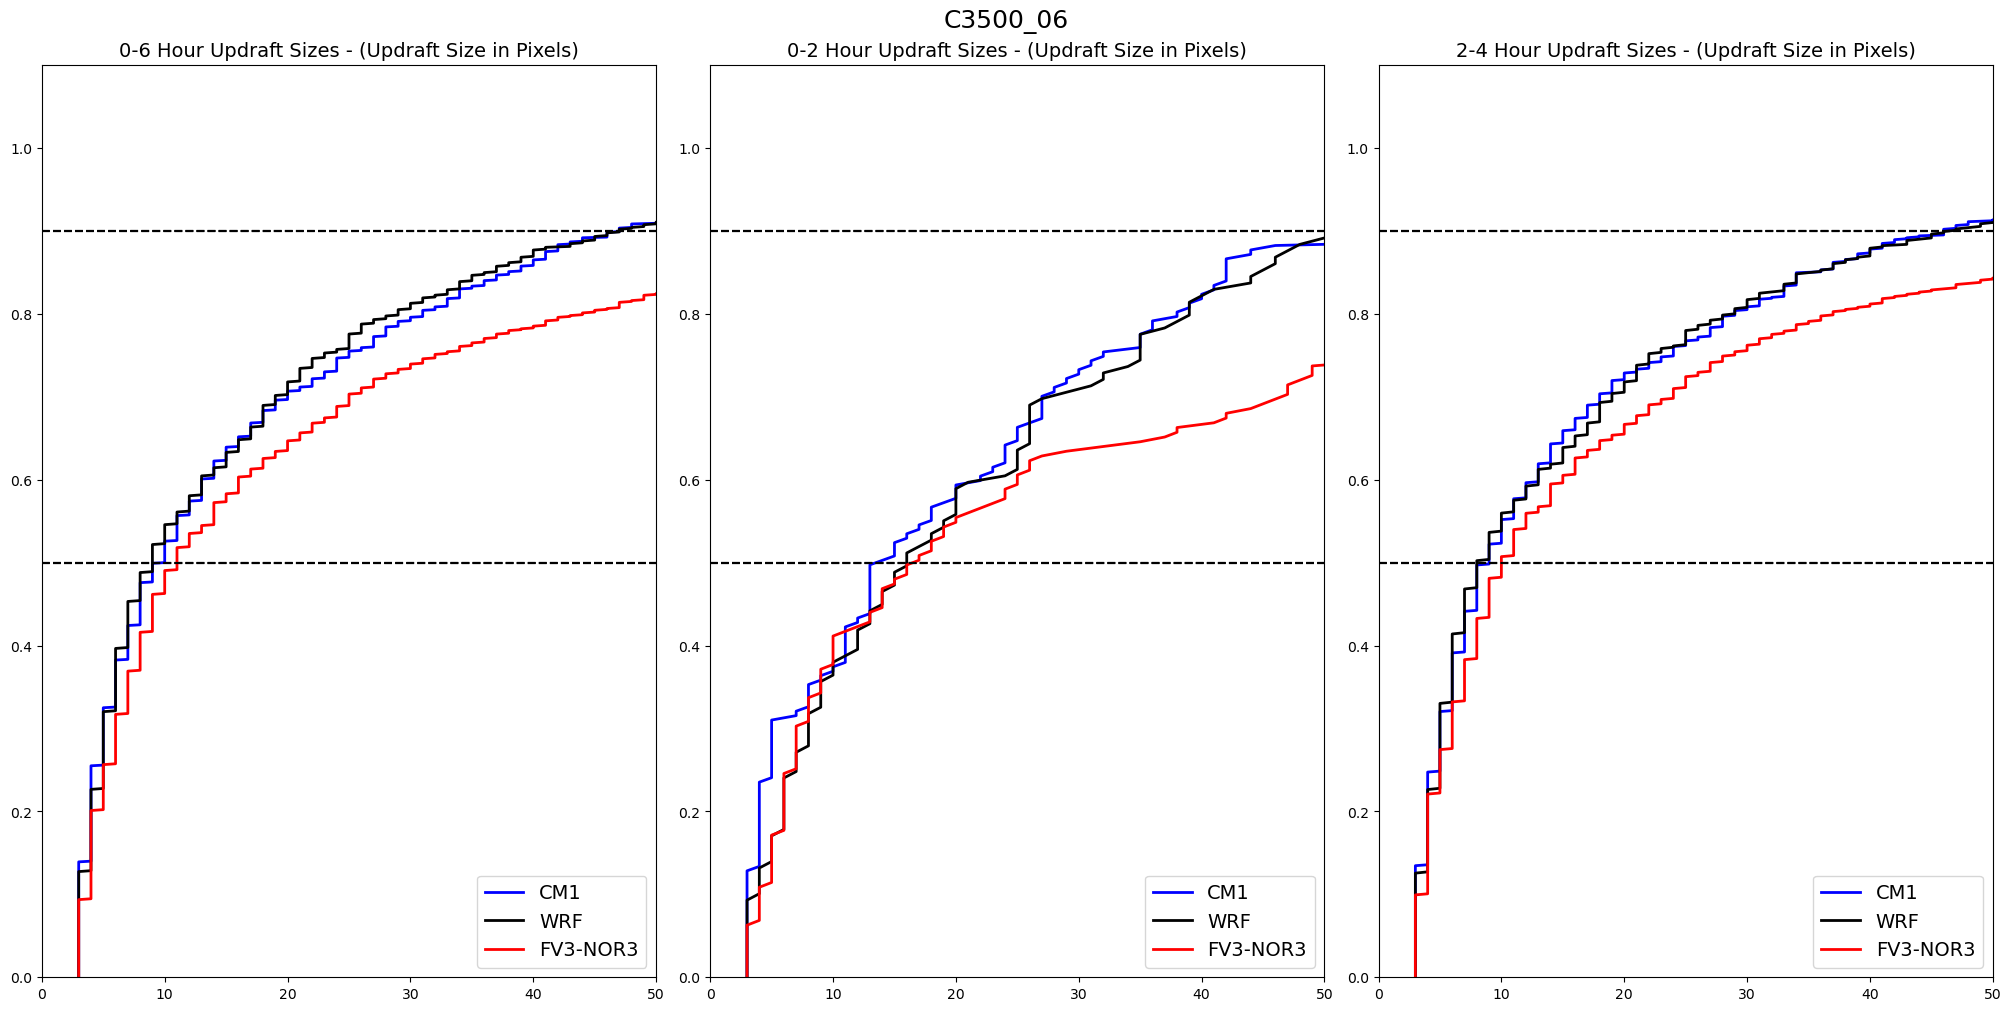

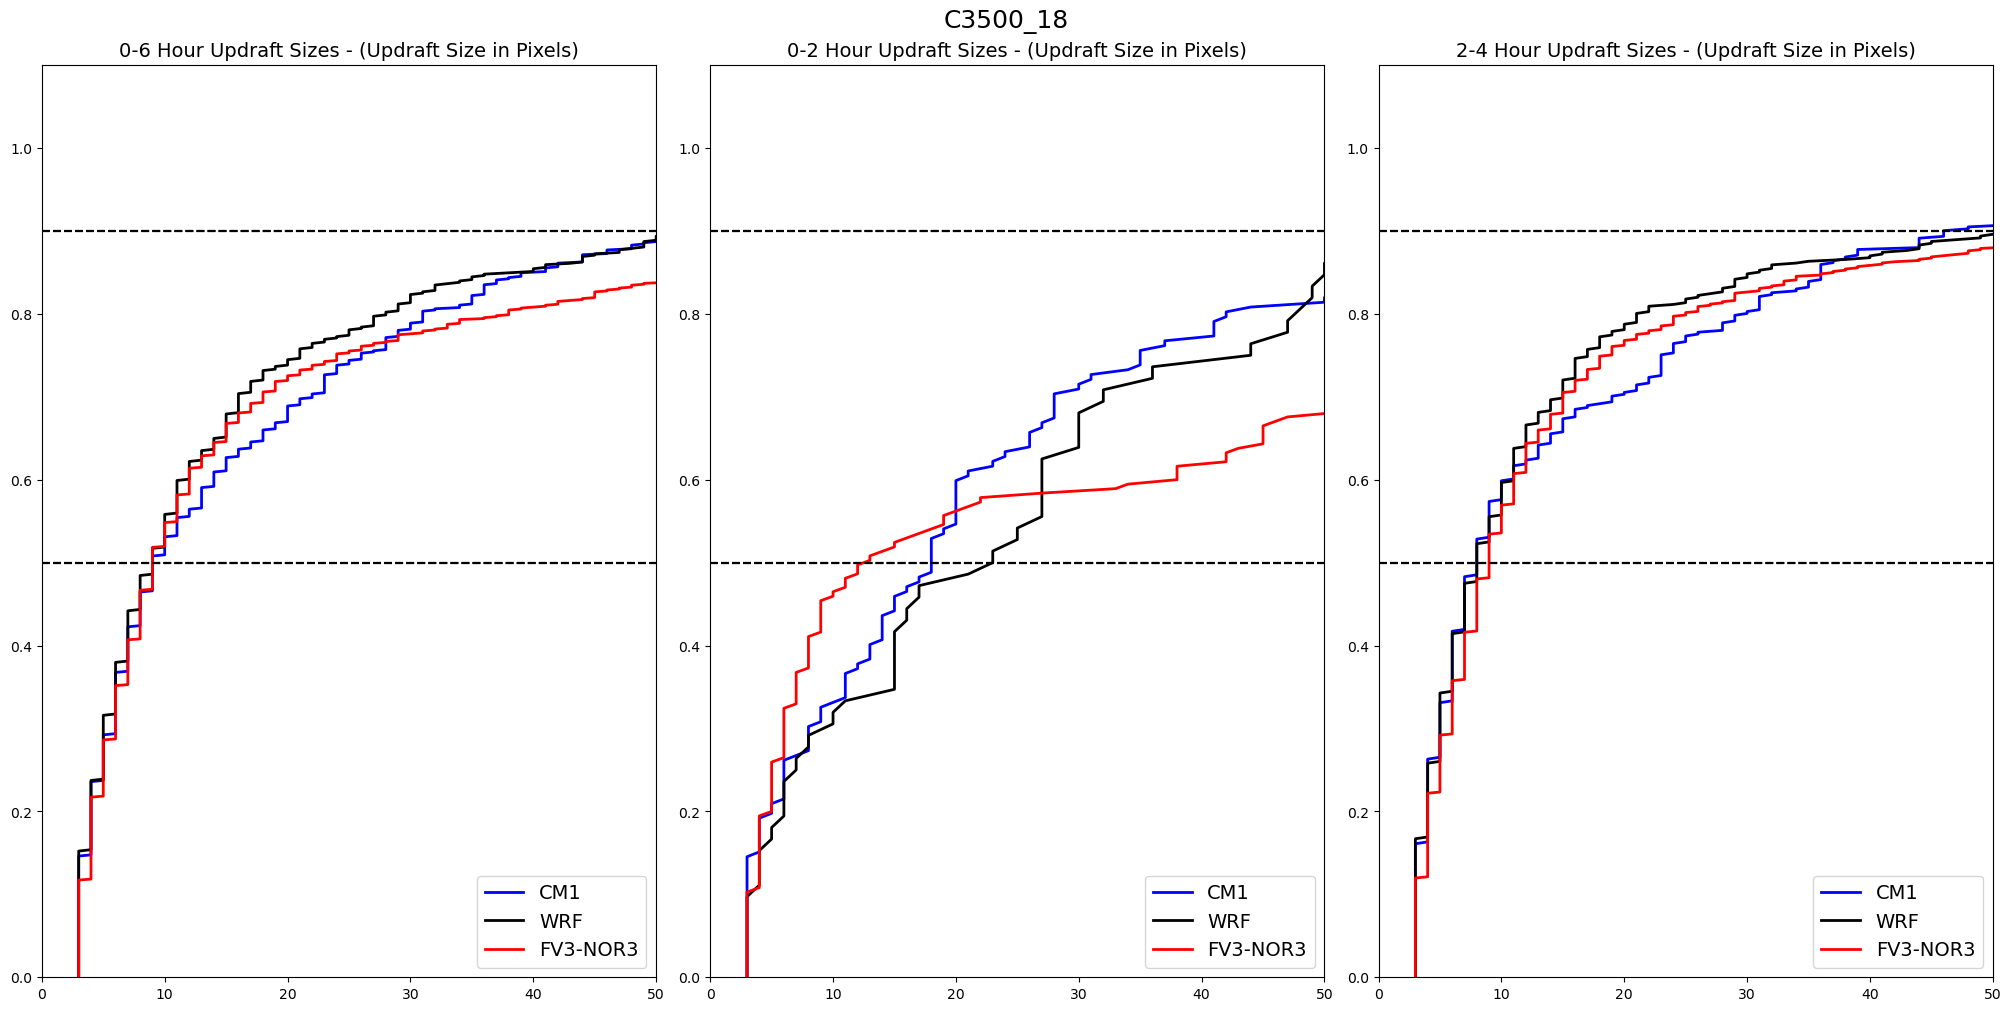

In [7]:
models = { 'cm1': pickle2Obj('profiles/cm1_squall_1km_35dbz_profiles.pkl',retObj=False),
           'wrf': pickle2Obj('profiles/wrf_squall_1km_35dbz_profiles.pkl', retObj=False),
           'solo': pickle2Obj('profiles/solo_squall_1km_35dbz_profiles.pkl',retObj=False)}
            
plot_sizes_driver( models, plabel = 'SQUALL_1km' )

In [ ]:
#--------------------------------------------------------------------------------------------
# define w / t / theta plotting

def plot_wptpth_driver(cm1, wrf, fv3, plabel = ""):

    titles = ["Updraft Profiles", "Pert. Temp Profiles", "Pert. Pressure (Pa) Profiles"]

    xvert  = [6.0, 8.0, 12.5]
    xlim   = [8., 15.0, 20.0]

    zhgts = 250. + 250.*np.arange(100)

    allcape = ( "C2000","C3500")
    allshear = ("06", "18")
    
    s = [1,24]
    m = 0

    for cape in allcape:

        label = []

        for shear in allshear:   # create dictionary names

            label.append("%s_%s" % (cape, shear))
        
        fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))
        
        for n, variable in enumerate(['w', 'pert_t', 'pert_p']):
                        
            plot_profile(cm1[label[0]], variable, zhgts, m, ax[n], 'b', 'CM1_06', step=s, linewidth=0.5)
            plot_profile(cm1[label[1]], variable, zhgts, m, ax[n], 'b', 'CM1_12', step=s, linewidth=1.0)
            plot_profile(cm1[label[2]], variable, zhgts, m, ax[n], 'b', 'CM1_18', step=s, linewidth=2.0)

            plot_profile(wrf[label[0]], variable, zhgts, m, ax[n], 'k', 'WRF_06', step=s, linewidth=0.5)
            plot_profile(wrf[label[1]], variable, zhgts, m, ax[n], 'k', 'WRF_12', step=s, linewidth=1.0)
            plot_profile(wrf[label[2]], variable, zhgts, m, ax[n], 'k', 'WRF_18', step=s, linewidth=2.0)
                        
            plot_profile(fv3[label[0]], variable, zhgts, m, ax[n], 'r', 'FV3_06', step=s, linewidth=0.5)
            plot_profile(fv3[label[1]], variable, zhgts, m, ax[n], 'r', 'FV3_12', step=s, linewidth=1.0)
            plot_profile(fv3[label[2]], variable, zhgts, m, ax[n], 'r', 'FV3_18', step=s, linewidth=2.0)

            
            ax[n].set_title("%s" % titles[n], fontsize=18)
                                      
            ax[n].axhline(y=6000., color='k', linestyle='-')
            ax[n].axhline(y=8000., color='k', linestyle='-')
            ax[n].axhline(y=10000., color='k', linestyle='-')
            ax[n].axhline(y=12000., color='k', linestyle='-')

            ax[n].set_ylim(0.0,25000.) 
                                       
            if n == 0:
                ax[n].axvline(x=0.0, color='k', linestyle='--')
                ax[n].axvline(x=xvert[n], color='k', linestyle='--')
                ax[n].legend(fontsize=12, loc='upper right')
                ax[n].set_xlim(-3.0,xlim[n])
               
            elif n == 1:
                ax[n].legend(fontsize=12, loc='upper left')
                ax[n].axvline(x=0.0, color='k', linestyle='--')
                ax[n].set_xlim(-7.,7.0)
            else:
                ax[n].legend(fontsize=12, loc='upper left')
                ax[n].axvline(x=0.0, color='k', linestyle='--')
                ax[n].set_xlim(-800, 400)

        plt.suptitle("%s  CAPE = %s" % (plabel, cape[1:]), fontsize=24)
        plt.show()
        
#######################